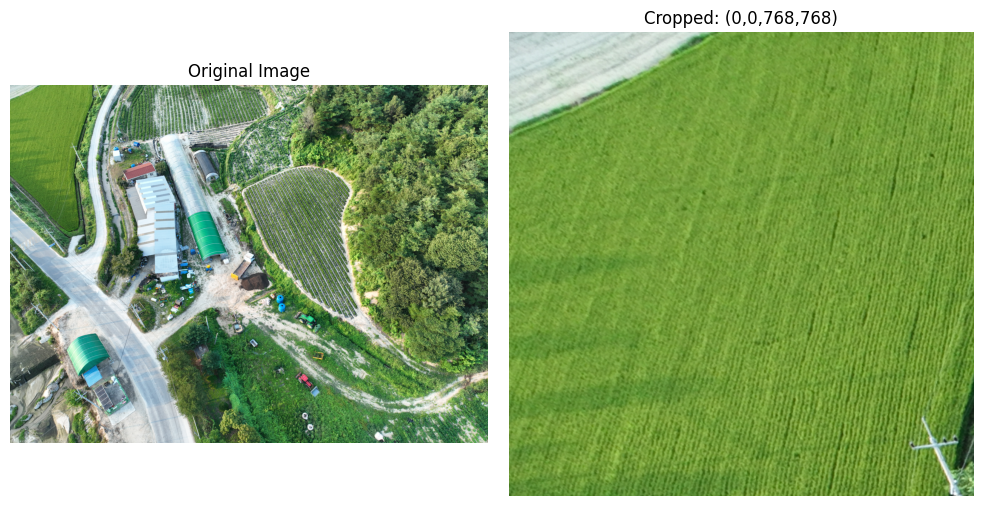

In [ ]:
"""
이미지 크롭 테스트 노트북
========================
이 노트북은 이미지 크롭 기능을 테스트하는 간단한 예제입니다.
대용량 이미지에서 특정 영역을 잘라내어 처리하는 방법을 보여줍니다.

사용 목적:
- 이미지 전처리 테스트
- 크롭 영역 설정 확인
- 시각화 및 검증
"""

from PIL import Image
import matplotlib.pyplot as plt

# ==================== 이미지 로드 ====================
# 1. 이미지 열기
img_path = "./encumbrance_labels/encumbrance/DJI_0008.JPG"  # 테스트용 이미지 경로
image = Image.open(img_path).convert("RGB")  # RGB 형식으로 변환

print(f"원본 이미지 크기: {image.size}")

# ==================== 크롭 설정 ====================
TARGET_SIZE = 1008  # OWLv2 최적 입력 크기로 수정

# 2. Crop 영역 지정 (좌측상단 기준)
# 좌상단 (x, y), 크기 (width, height)
x, y = 0, 0                    # 시작 좌표 (좌측 상단 기준)
crop_width = TARGET_SIZE       # 자를 영역의 너비
crop_height = TARGET_SIZE      # 자를 영역의 높이

# 3. crop 영역 계산: (left, upper, right, lower)
crop_box = (x, y, x + crop_width, y + crop_height)
print(f"크롭 영역: {crop_box}")

# ==================== 4단계: 이미지 크롭 실행 ====================
# 계산된 크롭 영역으로 이미지 자르기
cropped_image = image.crop(crop_box)
print(f"크롭된 이미지 크기: {cropped_image.size}")

# ==================== 5단계: 원본 및 크롭된 이미지 시각화 ====================
# matplotlib을 사용하여 원본과 크롭된 이미지를 나란히 비교
plt.figure(figsize=(10, 5))

# 왼쪽: 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")  # 축 숨기기

# 오른쪽: 크롭된 이미지
plt.subplot(1, 2, 2)
plt.imshow(cropped_image)
plt.title(f"Cropped: ({x},{y},{x+crop_width},{y+crop_height})")
plt.axis("off")  # 축 숨기기

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

print("이미지 크롭 테스트 완료!")


In [ ]:
# ==================== 추가 테스트용 라이브러리 임포트 ====================
import json
from PIL import Image, ImageDraw, ImageFont
import torch
from torchvision.ops import nms
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# ==================== 폰트 설정 ====================
font = ImageFont.load_default()  # 텍스트 표시용 기본 폰트

# ==================== 디바이스 설정 ====================
# Apple Silicon (MPS) > NVIDIA GPU (CUDA) > CPU 순서로 선택
# 주석 처리된 코드는 이전 버전의 디바이스 선택 로직
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if device == "cpu":
#     device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 현재 사용 중인 디바이스 선택 로직
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU 우선
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # NVIDIA GPU 또는 CPU

print(f"사용 중인 디바이스: {device}")
    
print(f"Using device: {device}")  # 잘 된다면 cuda가 출력될 겁니다

processor = Owlv2Processor.from_pretrained(
    "google/owlv2-large-patch14-ensemble",
    image_size=1008,  
)
model = Owlv2ForObjectDetection.from_pretrained(
    "google/owlv2-large-patch14-ensemble"
).to(device).eval()

/home/dromii4/dromii/owlv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


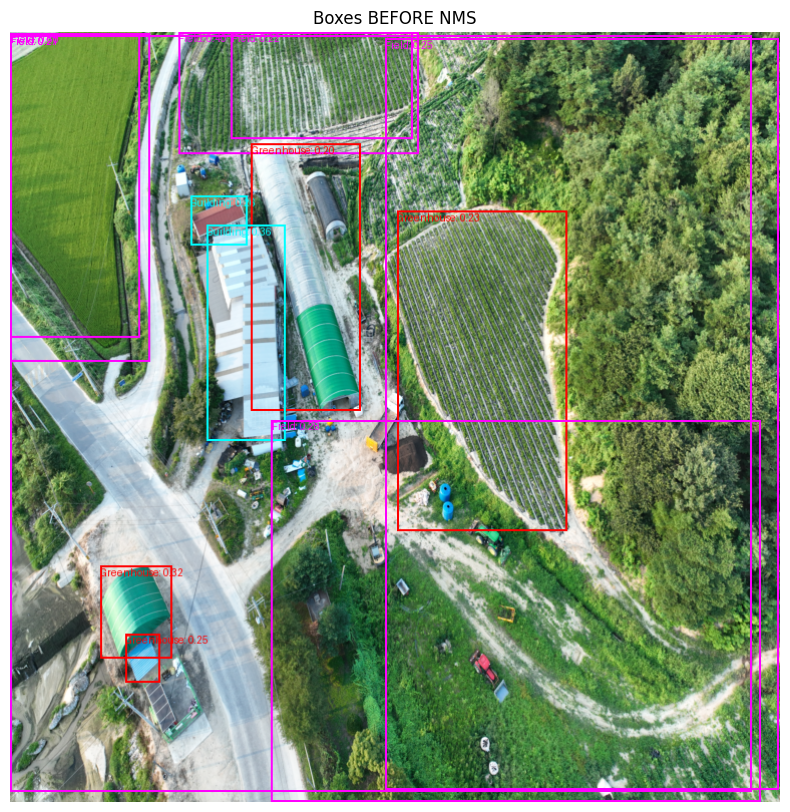

In [6]:
TEXT_QUERIES = [
    "Tomb", "Tree", "Greenhouse",
    "Building", "Field", "Container"
]

COLOR_MAP = {
    "Tomb":       (0,   0, 255),
    "Tree":       (0, 255,   0),
    "Greenhouse": (255, 0,   0),
    "Building":   (0, 255, 255),
    "Field":      (255, 0, 255),
    "Container":  (255, 255,   0),
}

THRESHOLD     = 0.2
IOU_THRESHOLD = 0.3

raw_image = Image.open(img_path).convert("RGB")
resized_image = image.resize((TARGET_SIZE, TARGET_SIZE), Image.BILINEAR)

input = resized_image
# input = cropped_image

w, h = input.size

# 2) OWLv2 입력 생성
inputs = processor(text=[TEXT_QUERIES], images=input, return_tensors="pt")
for k, v in inputs.items():
    if hasattr(v, "to"):
        inputs[k] = v.to(device)

# 3) 추론 + 후처리
with torch.no_grad():
    outputs = model(**inputs)
    
results = processor.post_process_object_detection(
    outputs=outputs,
    target_sizes=torch.tensor([[h, w]], device=device),
    threshold=THRESHOLD
)[0]

boxes, scores, labels = (
    results["boxes"],
    results["scores"],
    results["labels"],
)

image_all = input.copy()
draw_all = ImageDraw.Draw(image_all)
font = ImageFont.load_default()

for box, score, label_id in zip(results["boxes"], results["scores"], results["labels"]):
    label = TEXT_QUERIES[label_id]
    xmin, ymin, xmax, ymax = box.tolist()
    xmin, ymin = max(0, xmin), max(0, ymin)
    xmax, ymax = min(w, xmax), min(h, ymax)
    color = COLOR_MAP.get(label, (255, 255, 255))
    draw_all.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
    txt = f"{label}: {score:.2f}"
    draw_all.text((xmin, ymin), txt, fill=color, font=font)

plt.figure(figsize=(10, 10))
plt.imshow(image_all)
plt.axis("off")
plt.title("Boxes BEFORE NMS")
plt.show()

keep = nms(boxes, scores, IOU_THRESHOLD)
boxes, scores, labels = boxes[keep], scores[keep], labels[keep]




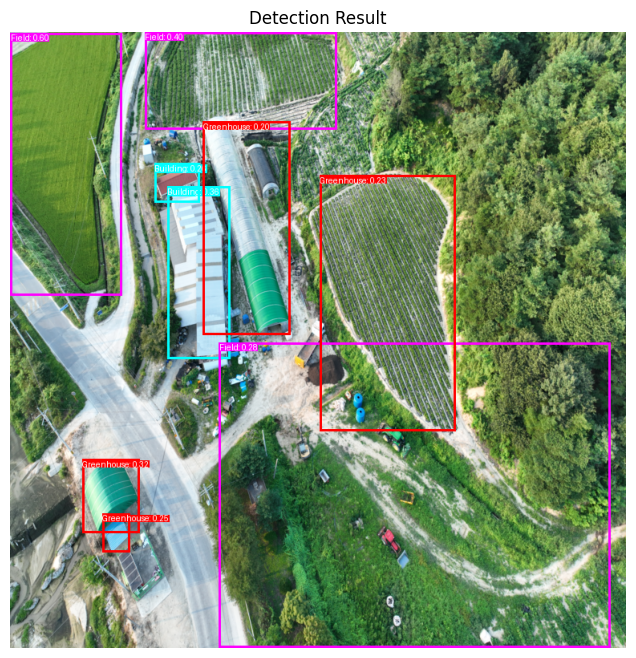

In [7]:
# 4) 시각화 & JSON 생성 (클램핑 포함)
draw = ImageDraw.Draw(input)
records = []
for box, score, li in zip(boxes, scores, labels):
    label = TEXT_QUERIES[li]
    xmin, ymin, xmax, ymax = box.tolist()
    
    # 클램핑
    xmin, ymin = max(0, xmin), max(0, ymin)
    xmax, ymax = min(w, xmax), min(h, ymax)
    color = COLOR_MAP.get(label, (255,255,255))

    draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)
    txt = f"{label}: {score:.2f}"
    x0, y0, x1, y1 = draw.textbbox((xmin, ymin), txt, font=font)
    draw.rectangle([x0, y0, x1, y1], fill=color)
    draw.text((xmin, ymin), txt, fill=(255,255,255), font=font)
    
plt.figure(figsize=(8, 8))
plt.imshow(input)
plt.axis('off')
plt.title("Detection Result")
plt.show()